In [102]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import os
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [103]:
import errno
import os
import urllib.request

def mkdir_p(path):
    """From https://stackoverflow.com/questions/600268/mkdir-p-functionality-in-python"""
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def maybe_download(url, local_dir, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    mkdir_p(local_dir)
    local_filename = url.split('/')[-1]
    local_filepath = os.path.join(local_dir, local_filename)
    if not os.path.exists(local_filepath):
        print("Downloading %s..." % local_filename)
        local_filename, _ = urllib.request.urlretrieve(url,
                                                       local_filepath)
        print("Finished!")
    statinfo = os.stat(local_filepath)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', local_filepath)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + local_filename +
                        '. Can you get to it with a browser?')
    return local_filename

out_dir = os.path.join('datasets', 'nmt_data_vi')
site_prefix = "https://nlp.stanford.edu/projects/nmt/data/"

maybe_download(site_prefix + 'iwslt15.en-vi/train.en', out_dir, 13603614)
maybe_download(site_prefix + 'iwslt15.en-vi/train.vi', out_dir, 18074646)

maybe_download(site_prefix + 'iwslt15.en-vi/vocab.en', out_dir, 139741)
maybe_download(site_prefix + 'iwslt15.en-vi/vocab.vi', out_dir, 46767)

Found and verified datasets/nmt_data_vi/train.en
Found and verified datasets/nmt_data_vi/train.vi
Found and verified datasets/nmt_data_vi/vocab.en
Found and verified datasets/nmt_data_vi/vocab.vi


'vocab.vi'

In [104]:
# set data path
data_dir = os.path.join('datasets', 'nmt_data_vi')
train_source = 'train.vi'
train_target = 'train.en'
train_source_dir = os.path.join(data_dir, train_source)
train_target_dir = os.path.join(data_dir, train_target)
vocab_source = 'vocab.vi'
vocab_target = 'vocab.en'
vocab_source_dir = os.path.join(data_dir, vocab_source)
vocab_target_dir = os.path.join(data_dir, vocab_target)

In [105]:
# load training sets
with open(train_source_dir) as f_source:
    sentences_source = f_source.readlines()
with open(train_target_dir) as f_target:
    sentences_target = f_target.readlines()

In [106]:
print("Total number of sentences in source training set: {}".format(len(sentences_source)))
print("Total number of sentences in target training set: {}".format(len(sentences_target)))

Total number of sentences in source training set: 133317
Total number of sentences in target training set: 133317


In [107]:
# load vocabularies
with open(vocab_source_dir) as f_vocab_source:
    #index2word_source = f_vocab_source.readlines()
    index2word_source = [line.rstrip() for line in f_vocab_source]
with open(vocab_target_dir) as f_vocab_target:
    #index2word_target = f_vocab_target.readlines()
    index2word_target = [line.rstrip() for line in f_vocab_target]

In [108]:
source_vocab_size = len(index2word_source)
target_vocab_size = len(index2word_target)
print("Total nummber of words in source vocabulary: {}".format(len(index2word_source)))
print("Total nummber of words in target vocabulary: {}".format(len(index2word_target)))

print(index2word_source)

Total nummber of words in source vocabulary: 7709
Total nummber of words in target vocabulary: 17191
['<unk>', '<s>', '</s>', 'Khoa', 'học', 'đằng', 'sau', 'một', 'tiêu', 'đề', 'về', 'khí', 'hậu', 'Trong', '4', 'phút', ',', 'chuyên', 'gia', 'hoá', 'quyển', 'Rachel', 'giới', 'thiệu', 'sơ', 'lược', 'những', 'nỗ', 'lực', 'khoa', 'miệt', 'mài', 'táo', 'bạo', 'biến', 'đổi', 'cùng', 'với', 'đoàn', 'nghiên', 'cứu', 'của', 'mình', '--', 'hàng', 'ngàn', 'người', 'đã', 'cống', 'hiến', 'cho', 'dự', 'án', 'này', 'chuyến', 'bay', 'mạo', 'hiểm', 'qua', 'rừng', 'già', 'để', 'tìm', 'kiếm', 'thông', 'tin', 'phân', 'tử', 'then', 'chốt', '.', 'Tôi', 'muốn', 'các', 'bạn', 'biết', 'sự', 'to', 'lớn', 'góp', 'phần', 'làm', 'nên', 'dòng', 'tít', 'thường', 'thấy', 'trên', 'báo', 'Có', 'trông', 'như', 'thế', 'khi', 'bàn', 'và', 'nói', 'chất', 'lượng', 'không', 'hay', 'khói', 'bụi', 'Cả', 'hai', 'đều', 'là', 'nhánh', 'lĩnh', 'vực', 'trong', 'ngành', 'Các', 'gần', 'đây', 'Ban', 'Điều', 'hành', 'Biến', 'Liên', 'ch

In [109]:
word2index_source = {}
for idx, word in enumerate(index2word_source):
    word2index_source[word] = idx
word2index_target = {}
for idx, word in enumerate(index2word_target):
    word2index_target[word] = idx
print(index2word_target)

['<unk>', '<s>', '</s>', 'Rachel', ':', 'The', 'science', 'behind', 'a', 'climate', 'headline', 'In', '4', 'minutes', ',', 'atmospheric', 'chemist', 'provides', 'glimpse', 'of', 'the', 'massive', 'scientific', 'effort', 'bold', 'headlines', 'on', 'change', 'with', 'her', 'team', '--', 'one', 'thousands', 'who', 'contributed', 'taking', 'risky', 'flight', 'over', 'rainforest', 'in', 'pursuit', 'data', 'key', 'molecule', '.', 'I', '&apos;d', 'like', 'to', 'talk', 'you', 'today', 'about', 'scale', 'that', 'goes', 'into', 'making', 'see', 'paper', 'look', 'this', 'when', 'they', 'have', 'do', 'and', 'air', 'quality', 'or', 'smog', 'They', 'are', 'both', 'two', 'branches', 'same', 'field', 'Recently', 'looked', 'Panel', 'Climate', 'Change', 'IPCC', 'put', 'out', 'their', 'report', 'state', 'understanding', 'system', 'That', 'was', 'written', 'by', 'scientists', 'from', '40', 'countries', 'wrote', 'almost', 'thousand', 'pages', 'topic', 'And', 'all', 'those', 'were', 'reviewed', 'another', '

In [110]:
# Preparing Data
def sen2idx(sentence, word2index):
    return [word2index.get(word, 0) for word in sentence.split(' ')] # assume that 0 is for <unk>

def sen2tensor(sentence, word2index):
    idxes = sen2idx(sentence, word2index)
    idxes.append(EOS_token)
    return torch.tensor(idxes, dtype=torch.long, device=device)

In [111]:
# Parameters
MAX_LENGTH = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOS_token = 0
EOS_token = 1

hidden_size = 512

# model class

In [112]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
    def forward(self, input, prev_h, prev_c):
        input_embedded = self.embedding(input)
        h, c = self.lstm(input_embedded, (prev_h, prev_c))
        return h, c
    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

In [113]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, prev_h, prev_c):
        input_embedded = self.embedding(input)
        h, c = self.lstm(input_embedded, (prev_h, prev_c))
        output =self.softmax(self.out(h))
        return output, h, c
    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

In [114]:

class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
#         self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTMCell(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, prev_h, prev_c, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], prev_h), 1)), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        h, c = self.lstm(output[0], (prev_h, prev_c))

        output = F.log_softmax(self.out(h))
        return output, h, c, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# training

In [115]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, max_length=MAX_LENGTH):
    encoder_hidden_h = encoder.initHidden()
    encoder_hidden_c = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    criterion = nn.NLLLoss()
    
#     print(input_length)
    
    for ei in range(min(input_length, max_length)):
        encoder_hidden_h, encoder_hidden_c = encoder(input_tensor[ei].view(1), encoder_hidden_h, encoder_hidden_c)
        encoder_outputs[ei] = encoder_hidden_h[0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden_c = encoder_hidden_c
    decoder_hidden_h = encoder_hidden_h
    
    for di in range(target_length):
        decoder_output, decoder_hidden_h, decoder_hidden_c, decoder_attention = decoder(
                decoder_input, decoder_hidden_h, decoder_hidden_c, encoder_outputs)

        loss += criterion(decoder_output, target_tensor[di].view(1))
        decoder_input = target_tensor[di]  # Teacher forcing

    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [116]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), learning_rate)
    
    for iter in range(1, n_iters+1):
        input_tensor = sen2tensor(sentences_source[iter-1], word2index_source)
        target_tensor = sen2tensor(sentences_target[iter-1], word2index_target)
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter%print_every ==0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

# evaluate

In [117]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = sen2tensor(sentence, word2index_source)
        input_length = input_tensor.size()[0]
        encoder_hidden_h = encoder.initHidden()
        encoder_hidden_c = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        
        for ei in range(min(input_length, max_length)):
            encoder_hidden_h, encoder_hidden_c = encoder(input_tensor[ei].view(1), encoder_hidden_h, encoder_hidden_c)
            encoder_outputs[ei] = encoder_hidden_h[0]
        
        '''
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        '''

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        decoder_hidden_c = encoder_hidden_c
        decoder_hidden_h = encoder_hidden_h
        
    
        for di in range(max_length):
            decoder_output, decoder_hidden_h, decoder_hidden_c, decoder_attention = decoder(
                    decoder_input, decoder_hidden_h, decoder_hidden_c, encoder_outputs)
            
            decoder_attentions[di] = decoder_attention.data
            print('output: ', decoder_output)
            topv, topi = decoder_output.data.topk(1)
            print('topv:', topv)
            print('topi:', topi)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                print(topi)
                decoded_words.append(index2word_target['%d'%topi.item()])
            decoder_input = topi.squeeze().detach()
            
        '''
            loss += criterion(decoder_output, target_tensor[di].view(1))
            decoder_input = target_tensor[di]

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        '''
        return decoded_words, decoder_attentions[:di + 1]

# show attention

In [118]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(encoder, decoder, input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [119]:
#encoder1 = EncoderLSTM(source_vocab_size, hidden_size).to(device)
#decoder1 = DecoderLSTM(hidden_size, target_vocab_size).to(device)
#trainIters(encoder1, decoder1, 133317, print_every=1)

In [120]:
encoder2 = EncoderLSTM(source_vocab_size, hidden_size).to(device)
decoder2 = AttnDecoderLSTM(hidden_size, target_vocab_size).to(device)
trainIters(encoder2, decoder2, 100, print_every=10)

/Users/xiaoming/anaconda3/envs/deeprlbootcamp/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(10 10%) 9.6589
(20 20%) 9.2081
(30 30%) 7.7096
(40 40%) 7.1107
(50 50%) 6.8943
(60 60%) 7.0107
(70 70%) 6.6624
(80 80%) 6.8324
(90 90%) 6.7240
(100 100%) 6.3620


# evaluation

17191
<class 'str'>
output:  tensor([[ -4.2835,  -1.9450, -10.5246,  ..., -10.1571, -10.2199,
         -10.5588]])
topv: tensor([[-1.9450]])
topi: tensor([[ 1]])
input = Mỗi năm , hơn 15,000 nhà khoa học đến San Francisco để tham dự hội nghị này .

output = <EOS>


/Users/xiaoming/anaconda3/envs/deeprlbootcamp/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


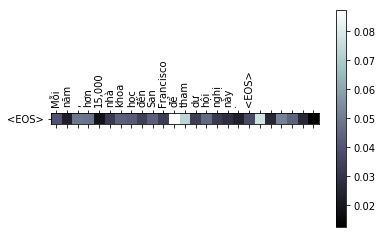

In [123]:
test_s = (sentences_source[10])
print(len(index2word_target))
print(type(sentences_source[0]))

evaluateAndShowAttention(encoder2, decoder2, test_s)
